# Conformal prediction for wind speed forecasting
This notebook goes through the training and testing of conformal predictors for wind speed forecasting as well as a Quantile Random Forest regressor for reference. 

In [1]:
import numpy as np
from data.dataimport import dataimport
from models.conformal_nex import Conformal_nex
from models.conformal_nxg import Conformal_nxg
from models.conformal_std import Conformal_std
from models.forest_qr import RanForestQuantile
import matplotlib.pyplot as plt
from mod_tr_schedule import train_schedule, crps
from scipy.stats import beta

### CRPS
We use continuous ranked probability scores for model selection and evaluation. The code below code is test of the implementation, we use the trapezoidal rule and we roughly expect the values here to be [0.07, 0.11, 0.04, 0.06, 0.04, 0.05, 0.05, 0.36, 0.21, 0.12] [source](https://www.sciencedirect.com/science/article/pii/S2666546821000124).

In [2]:
length = 500
distr = beta.ppf(np.linspace(0,1,num=length),2,5)
obs = np.array([0.149, 0.095, 0.287, 0.355, 0.226, 0.192, 0.214, 0.734, 0.572, 0.084])
preds = np.empty((len(obs),length))
for i in range(len(obs)):
    print(crps(distr.reshape(1,-1), obs[i].reshape(1,-1)))



0.0706850642343868
0.10677900295670256
0.04023193789300933
0.056967253427799736
0.04245291800355425
0.0512823964001025
0.04486130172907091
0.3447689225030263
0.20420802238271388
0.1154637442759435


## Training schedule
We use a training schedule for testing the models. It works by splitting the data into a number of different trianing / validation data configurations. It then runs each desired model through all configurations. The one making the best predictions on the validation data will be trained on all the data before making the next prediction. The prediction is saved as a result before the corresponding data point is added to the training set and the process is ran again. This tries to mimic what one would actually do in the real world, meaning that each test point can be predicted with different hyper-parameters. The data splitting and model choice implementations can be found in `mod_tr_schedule.py` for a detailed view. However in general it works in the following:
1. Number of splits $k$ is passed together with data and model (parameters)
2. For each set of model-parameters
    1. Train model on $\mod(n,k) $ points to start
    2. Predict the value of every $k$:th point there after and train the model in between
    3. Shift the points to predict with one step and run through data-set again
    4. Repeat until the model has run through the training-set $k$ times
3. Determine which set of model-parameters performs best on the validation data through some scoring scheme
4. Train that model on all the training data and predict the next test-point
5. Add the prediction as a result and add the next test-point to the training set
6. Repeat for all test-points


There is an alternative version used for two of the models, where instead of predicting each $k$:th point we create $k$ blocks, train/calibrate the models on the other data before predicting that block. Then we move on to train the models again and predict on the next block. It is similar to the first version just that it requires less retraining instanciations for the models that can't handle concatenation to their training set.

## The data
The data split into three parts: the ensemble forecasts, the post-processed forecasts and the measured values of wind speed near or at Måseskär outside the west coast of Sweden. The forecasts comes from the Norwegian Meteorological Institute (MET) and their [public data](https://thredds.met.no/thredds/catalog.html) while the measurements comes from [SMHI](https://www.smhi.se/data/meteorologi/ladda-ner-meteorologiska-observationer/#param=wind,stations=core). The forecasts are 24-hour ahead collected at noon for four months between Septembre 2022 and January 2023. Points with missing post-processed forecasts, measured data or more than 25% of ensemble have been removed. Ensemble data with less than 25% missing values have been bootstrapped to compensate. The `fcdates` object is a list of reference dates. Each data object are split into two, one for intial training and one for testing, dates for the split can be found in the `dataimport.py` file.


In [2]:
inp_data, forecasts, measurements, fcdates = dataimport()
print(str(fcdates[0][0]) + " - " + str(fcdates[0][-1]))
print(str(fcdates[1][0]) + " - " + str(fcdates[1][-1]))
print(fcdates[0].shape)
print(fcdates[1].shape)


2022-01-02 12:00:00 - 2022-03-01 12:00:00
2022-03-02 12:00:00 - 2023-01-23 12:00:00
(55,)
(314,)


Text(0, 0.5, 'wind speed')

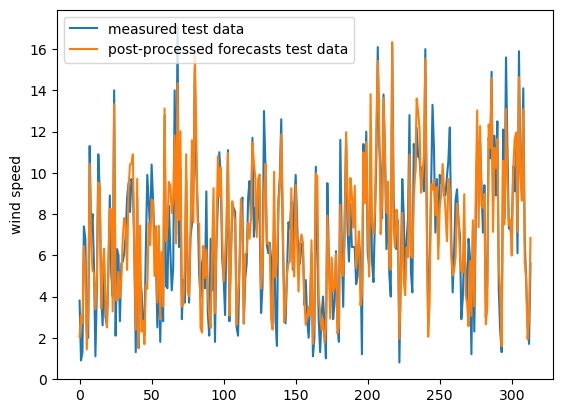

In [8]:
plt.plot(measurements[1],label = 'measured test data')
plt.plot(forecasts[1],label = 'post-processed forecasts test data')
plt.legend()
plt.ylabel('wind speed')

## The models
Below we will predict the first sample of the test data, to get a feeling of what all the models are doing, before we move on to using the training schedule.

# Conformal predictive distribution system
This is the "standard" implementation of the cpds. It uses the crepes library developed by Henrik Boström at KTH. Currently the "normalized" version is used with default values for generating the difficulty estimates. See Crepes [Github](https://github.com/henrikbostrom/crepes) page for detailed information about the library. Here the entire cpds for each prediction is return, all values below the minimum (0) are truncated to that value and the minimum and maximun values are added to the start and end points. After that the distribution (CDF) is interpolated (linear) to 200 points for consistency across all models and test cases.

Note: the variable mod_params is a list of dictionaries that are passed to the model constructors. It should contain all the versions of the models we wish to test. This is the case for all models in the module.

(0.0, 10.0, 0.0, 1.0)

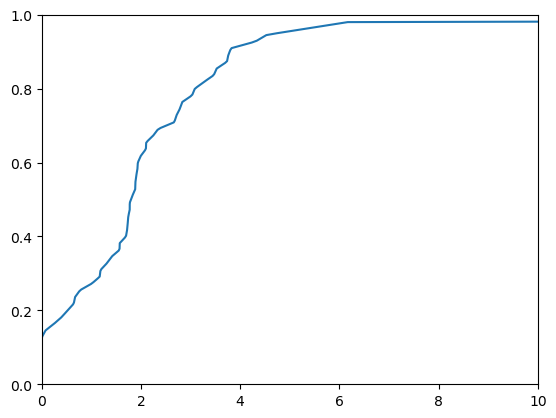

In [9]:
conf_std = Conformal_std(diff_estimate=5)
conf_std.calibrate(inp_data[0],forecasts[0],measurements[0])
pred = conf_std.predict(inp_data[1][0,:],forecasts[1][0])
plt.plot(pred,np.linspace(0,1,len(pred)))
plt.axis([0,10,0,1])

## Non-exchangeable conformal predictor
This is the non-exchangeable split conformal predictor described in [this article](https://arxiv.org/abs/2202.13415) by Barber et. al., assuming that the undelying model is trained on other data. It currently allows one to change the forget factor as model input. The conformity scores here are only based on the residuals of the predictions. This system is originally only used for set predictions and not probabilistic predictions. The set predictions are transformed to probabilistic predictions by sequentially adding on larger and larger prediction intervals corresponding to different confidence levels. As before, values below the minimum value are truncated and then everything is interpolated to 200-points.

(0.0, 10.0, 0.0, 1.0)

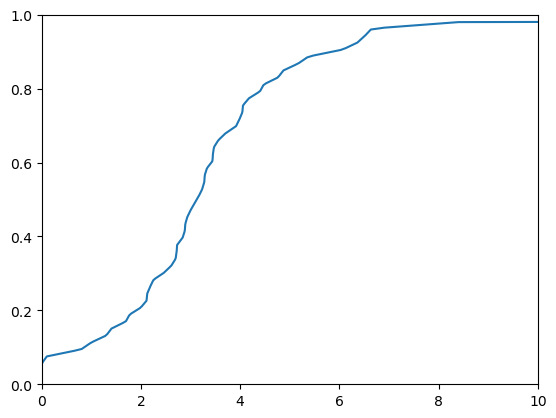

In [10]:
conf_std = Conformal_nex(0.99)
conf_std.calibrate(inp_data[0],forecasts[0],measurements[0])
pred = conf_std.predict(inp_data[1][1,:],forecasts[1][1])
plt.plot(pred,np.linspace(0,1,len(pred)))
plt.axis([0,10,0,1])

## Non-exchangeable conformal predictor with custom conformity score
This predictor is based on the same article as above but employs a custom conformity score described by

$\alpha_i = a |y_i - \hat{y}_i| - \mathbf{w}^T \mathbf{V(x_i)}$ 

where $\mathbf{V(x_i)}$ is the variance of each variable in the ensemble input and $a$ and $\mathbf{w}$ are weights passed as model parameters. The thought is that the larger the varaince the more uncertain a prediction should be.

(0.0, 10.0, 0.0, 1.0)

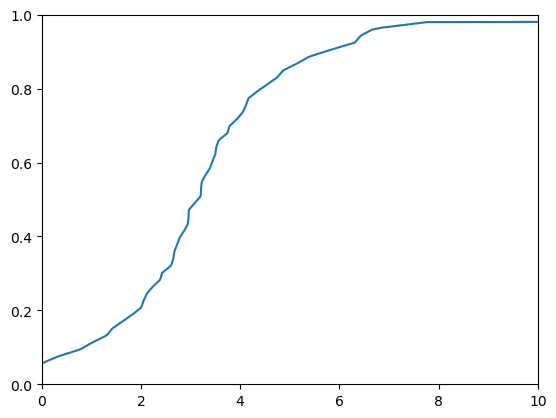

In [11]:
conf_std = Conformal_nxg(0.99,0.95,np.array([0.02, 0.02]),2)
conf_std.calibrate(inp_data[0],forecasts[0],measurements[0])
pred = conf_std.predict(inp_data[1][1,:],forecasts[1][1])
plt.plot(pred,np.linspace(0,1,len(pred)))
plt.axis([0,10,0,1])

# Quantile random forest
The quantile random forest is a generalisation of the random forest algorithm used to predict quantiles. The algorithm used here is taken from this [Github](https://github.com/zillow/quantile-forest). The algorthm produces a number of quantiles of the CDF and linearly interpolates between those.  As before, the start and end points are added, values below the minimum are truncated. The algorithm solves the linear interpolation itself, we don't have to do that.

(0.0, 15.0, 0.0, 1.0)

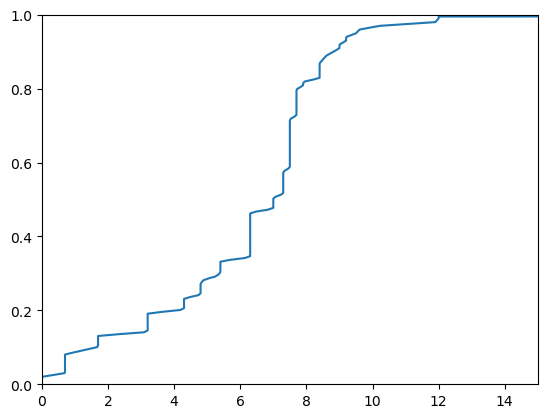

In [14]:
qrf = RanForestQuantile()
qrf.calibrate(inp_data[0],forecasts[0],measurements[0])
pred = qrf.predict(np.squeeze(inp_data[1][0,:]),np.squeeze(forecasts[1][0]))
plt.plot(pred,np.linspace(0,1,len(pred)))
plt.axis([0 ,15,0,1])

### Conformal

In [18]:
mod_params = [{'window_length':np.inf},{'window_length':200}, {'window_length':100}, {'window_length':50}]
pred_cpds, mods_cpds = train_schedule(Conformal_std, mod_params, inp_data[0], forecasts[0], measurements[0], inp_data[1], forecasts[1], measurements[1], num_splits=5, block_training=True)
print('Accuracy 0.9: ' + str(np.sum((np.squeeze(measurements[1]) > pred_cpds[:,10]) & (np.squeeze(measurements[1]) < pred_cpds[:,189]))/len(measurements[1])))
print('Width 0.9: ' + str(np.mean(pred_cpds[:,189]-pred_cpds[:,10])))
print('Accuracy 0.5: ' + str(np.sum((np.squeeze(measurements[1]) > pred_cpds[:,50]) & (np.squeeze(measurements[1]) < pred_cpds[:,149]))/len(measurements[1])))
print('Width 0.5: ' + str(np.mean(pred[:,149]-pred_cpds[:,50])))
print('CRPS: ' + str(crps(pred_cpds,measurements[1])))

100%|██████████| 314/314 [03:07<00:00,  1.68it/s]

Accuracy 0.9: 0.9171974522292994
Width 0.9: 7.499708775666303
Accuracy 0.5: 0.5254777070063694
Width 0.5: 2.108905915272515
CRPS: 0.8925541856439363


In [28]:
for i in range(len(mod_params)):
    k = 0
    for mod in mods_cpds:
        if mod_params[i] == mod:
            k +=1
    print(str(i+1)+": " +str(k/len(mods_cpds)))


1: 0.44904458598726116
2: 0.1305732484076433
3: 0.28662420382165604
4: 0.1337579617834395


(250.0, 314.0, 0.0, 20.0)

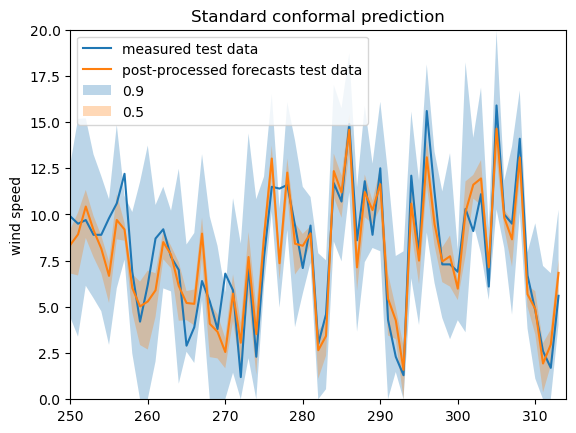

In [19]:
plt.plot(measurements[1],label = 'measured test data')
plt.plot(forecasts[1],label = 'post-processed forecasts test data')
plt.fill_between(range(len(measurements[1])),pred_cpds[:,10], y2 = pred_cpds[:,189], alpha = 0.3, label = '0.9')
plt.fill_between(range(len(measurements[1])),pred_cpds[:,50], y2 = pred_cpds[:,149], alpha = 0.3, label = '0.5')
plt.legend()
plt.ylabel('wind speed')
plt.title('Standard conformal prediction')
plt.axis([250, 314, 0, 20])

### Non-exchangeable conformal prediction

In [3]:
mod_params_nec = [ {'forget_factor':1},{'forget_factor':0.995}, {'forget_factor':0.99}, {'forget_factor':0.98},{'forget_factor':0.97}]
pred_nec, mods_nec = train_schedule(Conformal_nex, mod_params_nec, inp_data[0], forecasts[0], measurements[0], inp_data[1], forecasts[1], measurements[1], num_splits=5)
print('Accuracy 0.9: ' + str(np.sum((np.squeeze(measurements[1]) > pred_nec[:,10]) & (np.squeeze(measurements[1]) < pred_nec[:,189]))/len(measurements[1])))
print('Width 0.9: ' + str(np.mean(pred_nec[:,189]-pred_nec[:,10])))
print('Accuracy 0.5: ' + str(np.sum((np.squeeze(measurements[1]) > pred_nec[:,50]) & (np.squeeze(measurements[1]) < pred_nec[:,149]))/len(measurements[1])))
print('Width 0.5: ' + str(np.mean(pred_nec[:,149]-pred_nec[:,50])))
print('CRPS: ' + str(crps(pred_nec,measurements[1])))

100%|██████████| 314/314 [08:26<00:00,  1.61s/it]

Accuracy 0.9: 0.9299363057324841
Width 0.9: 6.0870121662364065
Accuracy 0.5: 0.5063694267515924
Width 0.5: 2.0621088135171117
CRPS: 0.8649039890204181


In [4]:
for i in range(len(mod_params_nec)):
    k = 0
    for mod in mods_nec:
        if mod_params_nec[i] == mod:
            k +=1
    print(str(i+1)+": " +str(k/len(mods_nec)))

1: 1.0
2: 0.0
3: 0.0
4: 0.0
5: 0.0


(250.0, 314.0, 0.0, 20.0)

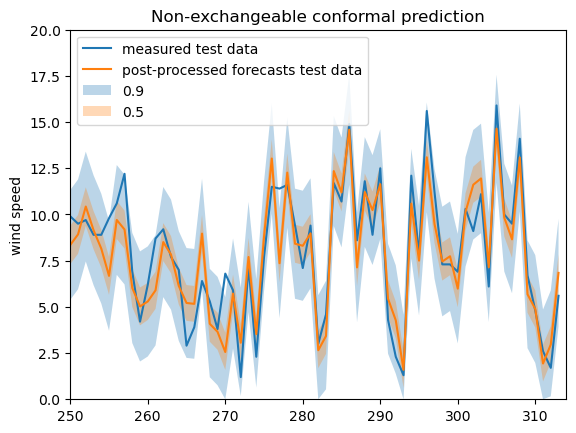

In [5]:
plt.plot(measurements[1],label = 'measured test data')
plt.plot(forecasts[1],label = 'post-processed forecasts test data')
plt.fill_between(range(len(measurements[1])),pred_nec[:,10], y2 = pred_nec[:,189], alpha = 0.3, label = '0.9')
plt.fill_between(range(len(measurements[1])),pred_nec[:,50], y2 = pred_nec[:,149], alpha = 0.3, label = '0.5')
plt.legend()
plt.ylabel('wind speed')
plt.title('Non-exchangeable conformal prediction')
plt.axis([250, 314, 0, 20])

### Non-exchangeable conformal prediction with custom conformity

In [5]:
mod_params_nxg = [{'forget_factor':1, 'input_factor': np.array([0, 0]), 'num_input_vars':2},{'forget_factor':1, 'input_factor': np.array([0.05, 0.05]), 'num_input_vars':2},{'forget_factor':1, 'input_factor': np.array([0.1, 0.1]), 'num_input_vars':2},{'forget_factor':0.99,  'input_factor': np.array([0, 0]), 'num_input_vars':2},{'forget_factor':0.99,  'input_factor': np.array([0.05, 0.05]), 'num_input_vars':2},{'forget_factor':0.99,  'input_factor': np.array([0.1, 0.1]), 'num_input_vars':2}]
pred_nxg, mods_nxg = train_schedule(Conformal_nxg, mod_params_nxg, inp_data[0], forecasts[0], measurements[0], inp_data[1], forecasts[1], measurements[1], num_splits=5)
print('Accuracy 0.9: ' + str(np.sum((np.squeeze(measurements[1]) > pred_nxg[:,10]) & (np.squeeze(measurements[1]) < pred_nxg[:,189]))/len(measurements[1])))
print('Width 0.9: ' + str(np.mean(pred_nxg[:,189]-pred_nxg[:,10])))
print('Accuracy 0.5: ' + str(np.sum((np.squeeze(measurements[1]) > pred_nxg[:,50]) & (np.squeeze(measurements[1]) < pred_nxg[:,149]))/len(measurements[1])))
print('Width 0.5: ' + str(np.mean(pred_nxg[:,149]-pred_nxg[:,50])))
print('CRPS: ' + str(crps(pred_nxg,measurements[1])))

100%|██████████| 314/314 [11:09<00:00,  2.13s/it]

Accuracy 0.9: 0.9299363057324841
Width 0.9: 6.0870121662364065
Accuracy 0.5: 0.5063694267515924
Width 0.5: 2.0621088135171117
CRPS: 0.8649039890204181


In [6]:
for i in range(len(mod_params_nxg)):
    k = 0
    for mod in mods_nxg:
        if str(mod_params_nxg[i]) == str(mod):
            k +=1
    print(str(i+1)+": " +str(k/len(mods_nxg)))

1: 1.0
2: 0.0
3: 0.0
4: 0.0
5: 0.0
6: 0.0


(250.0, 314.0, 0.0, 20.0)

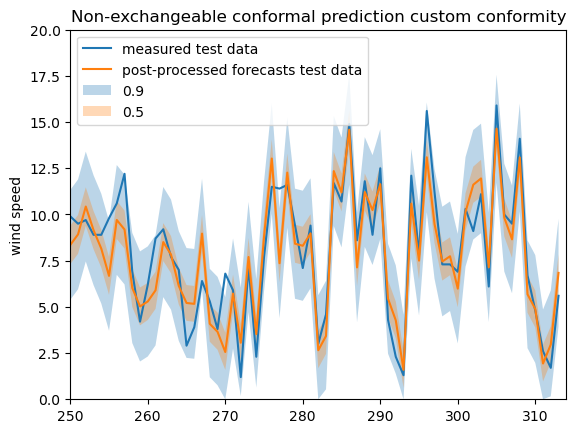

In [7]:
plt.plot(measurements[1],label = 'measured test data')
plt.plot(forecasts[1],label = 'post-processed forecasts test data')
plt.fill_between(range(len(measurements[1])),pred_nxg[:,10], y2 = pred_nxg[:,189], alpha = 0.3, label = '0.9')
plt.fill_between(range(len(measurements[1])),pred_nxg[:,50], y2 = pred_nxg[:,149], alpha = 0.3, label = '0.5')
plt.legend()
plt.ylabel('wind speed')
plt.title('Non-exchangeable conformal prediction custom conformity')
plt.axis([250, 314, 0, 20])

## Quantile random forest

In [24]:
mod_params_qrf = [{'num_trees':200,'window_length':100}, {'num_trees':100,'window_length':np.inf},{'num_trees':200,'window_length':np.inf}]
pred_qrf, mods_qrf = train_schedule(RanForestQuantile, mod_params_qrf, inp_data[0], forecasts[0], measurements[0], inp_data[1], forecasts[1], measurements[1], num_splits=5, block_training=True)
print('Accuracy 0.9: ' + str(np.sum((np.squeeze(measurements[1]) > pred_qrf[:,10]) & (np.squeeze(measurements[1]) < pred_qrf[:,189]))/len(measurements[1])))
print('Width 0.9: ' + str(np.mean(pred[:,189]-pred_qrf[:,10])))
print('Accuracy 0.5: ' + str(np.sum((np.squeeze(measurements[1]) > pred_qrf[:,50]) & (np.squeeze(measurements[1]) < pred_qrf[:,149]))/len(measurements[1])))
print('Width 0.5: ' + str(np.mean(pred_qrf[:,149]-pred_qrf[:,50])))
print('CRPS: ' + str(crps(pred_qrf,measurements[1])))

100%|██████████| 314/314 [41:16<00:00,  7.89s/it]

Accuracy 0.9: 0.8821656050955414
Width 0.9: 6.934797634927977
Accuracy 0.5: 0.5
Width 0.5: 2.3974554301787965
CRPS: 0.9206893583886702


In [31]:
for i in range(len(mod_params_qrf)):
    k = 0
    for mod in mods_qrf:
        if mod_params_qrf[i] == mod:
            k +=1
    print(str(i+1)+": " +str(k/len(mods_qrf)))

1: 0.17197452229299362
2: 0.0031847133757961785
3: 0.8248407643312102


(250.0, 314.0, 0.0, 20.0)

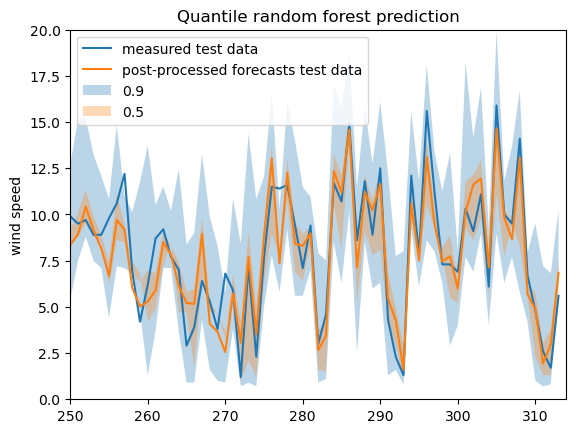

In [25]:
plt.plot(measurements[1],label = 'measured test data')
plt.plot(forecasts[1],label = 'post-processed forecasts test data')
plt.fill_between(range(len(measurements[1])),pred_qrf[:,10], y2 = pred[:,189], alpha = 0.3, label = '0.9')
plt.fill_between(range(len(measurements[1])),pred_qrf[:,50], y2 = pred[:,149], alpha = 0.3, label = '0.5')
plt.legend()
plt.ylabel('wind speed')
plt.title('Quantile random forest prediction')
plt.axis([250, 314, 0, 20])
